In [173]:
import tellurium as te 
import numpy as np 
import matplotlib.pyplot as plt
import ipywidgets as widgets 
from enum import Enum
from IPython.display import display

In [174]:
# Excitation and inhibition dictionaries

excite = {
  'komarova': lambda pop, k: f'{pop}/{k}',
  'lander':   lambda pop, a: f'{pop}/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'({pop}^{n})/(1+({a}*{pop})^{n})',
}

inhib = {
  'komarova': lambda pop, k: f'1-({pop}/{k})',
  'lander':   lambda pop, a: f'1/(1+{a}*{pop})',
  'hill':     lambda pop, a, n=4: f'1/(1+({a}*{pop})^{n})',
}



In [175]:
# Defining all functions: 

In [176]:
# Defining two stage model generator. 

def twoCompartmentModel(STEM='1', DIFF='0',
                        L='0.5', P='0.5', D='0.1',
                        Control=['1','1','1'], Events=[]):

    if (float(L)>1 or float(P)>1 or float(D)>1):
        raise ValueError('L, P, and D must be less than or equal to 1.')


    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    DIFF = {DIFF};

    # Parameters 
    L = {L}; P = {P}; D = {D};
    
    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_D:  STEM -> DIFF; P * 2 * L * STEM * ({Control[1]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; D * DIFF * ({Control[2]});

    #Events 
    {eventString}
    """

In [177]:
#Defining three stage model generator. 

def threeCompartmentModel(STEM='1', INTER='0', DIFF='0',
                        L_S='0.5', P_S='0.5', 
                        L_I='0.5', P_I='0.5',
                        D='0.1',
                        Control=['1','1','1','1','1'], Events=[]):

    eventString = '\n'.join(Events)

    return  f"""
    # Initialized Populations
    STEM = {STEM};
    INTER = {INTER};
    DIFF = {DIFF};

    # Parameters
    L_S = {L_S}; P_S = {P_S}; L_I = {L_I}; P_I = {P_I}; DEATH = {D};

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * ({Control[0]});

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * L_S * STEM * ({Control[1]});

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * STEM * ({Control[2]});

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * L_I * STEM * ({Control[3]});

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; DEATH * DIFF * ({Control[4]});

    #Events
    {eventString}
    """

In [178]:
def getMathematicaODEs(r):
  str = te.getODEsFromModel(r)
  strList = str.split('\n')[1:-1]
  rateDict = {}
  outStr = ''
  # print(strList)
  ratesflag = False

  for i in strList:
    if i == '':
      ratesflag = True
    elif not ratesflag:
      k, v = i.split(' = ')
      rateDict[k] = v
    else:
      str = ''
      for j in i.split(' '):
        if j in rateDict:
          str += rateDict[j]
        else:
          str += j
      outStr += f'{str}\n'
  return outStr

In [179]:
# PLOT FLOW DIAGRAMS
def plotFlow(modelStr: str,      # Antimony model string
                    max: float = 10, # max initial value
                    compartments: int = 3 # number of compartments
                    ):
  steps = 16 # number of steps between 0 and max
  nCurves = steps*1j # the number of curves that you want to plot
  n = np.arange(steps) # number to iterate over in for loops

  increments = np.mgrid[0:max:nCurves] # an array of all initial values

  U, V = np.mgrid[0:max:nCurves, 0:max:nCurves] # two n x n arrays to store population values at time t+1

  r = te.loada(modelStr) # load the model

  if compartments == 2:
    ogVals = {'STEM': r.STEM, 'DIFF': r.DIFF} # store the original initial population values of the model
    cellTypes = ['STEM', 'DIFF'] # list of cell types

  elif compartments == 3:
    ogVals = {'STEM': r.STEM, 'INTER': r.INTER, 'DIFF': r.DIFF}
    cellTypes = ['STEM', 'INTER', 'DIFF']

  # Create 3 subplots that are horizontally stacked
  _, ax = plt.subplots(1, compartments, sharey=False, figsize=(20, 5), dpi=128)

  # Iterate over each cell type
  for i in np.arange(compartments):
    cellA = cellTypes[i]        # the cell type plotted on the x-axis
    cellB = cellTypes[(i+1)%compartments]  # the cell type plotted on the y-axis

    if compartments == 3:
      cellX = cellTypes[(i-1)%compartments]  # the cell type that is not plotted

      r[cellX] = ogVals[cellX]    # set the cell type that is not plotted to its original value

    # iterate over the x-axis
    for x in n:
      r[cellA] = increments[x]    # set the initial value of the x-axis cell type

      # iterate over the y-axis
      for y in n:
        r[cellB] = increments[y]  # set the initial value of the y-axis cell type

        U[y,x] = r[f"{cellA}'"]   # store the value of the x-axis cell type at time t+1
        V[y,x] = r[f"{cellB}'"]   # store the value of the y-axis cell type at time t+1

    ax[i].set_xlabel(cellA, fontsize='12')
    ax[i].set_ylabel(cellB, fontsize='12')

    ax[i].streamplot(increments,increments,U, V, density=[2, 2]) # Plot the Flow

  plt.show()  

In [180]:
# Bifurcation scans
class Params(Enum):
  # two compartments
  L = 'L'
  P = 'P'
  D = 'D'
  # three compartments
  L_S = 'L_S'
  L_I = 'L_I'
  P_S = 'P_S'
  P_I = 'P_I'  
  
  STEM = 'STEM'
  INTER = 'INTER'
  DIFF = 'DIFF'
    
# First version
def printHighLowBifurcationScan(modelStr: str,
                                scanningParam: Params = Params.L_S,                                
                                highLow: Params = Params.STEM,
                                range: np.array = np.arange(0, 2, 0.01),                                
                                lowInit: float = 0.1,
                                highInit: float = 20.0,
                                simulateLen: int = 1000,
                                titleAppend: str = ''):
  try:
    r = te.loada(modelStr)
    results = np.empty([0,3])
    for param in range:
      r.resetAll()

      r[highLow.value] = lowInit      
      r[scanningParam.value] = param
      m = r.simulate(0, simulateLen, 1000)
      lowEnding = r[highLow.value]
      r.resetAll()

      r[highLow.value] = highInit
      r[scanningParam.value] = param      
      m = r.simulate(0, simulateLen, 1000)
      highEnding = r[highLow.value]

      newRow = [param, lowEnding, highEnding]
      results = np.vstack([ results, newRow ])
    te.plotArray(results,
                title="{} Bifurcation Scan {}".format(titleAppend, scanningParam), 
                resetColorCycle=False, 
                labels=[ "{}_low".format(highLow.value), "{}_high".format(highLow.value) ])
  except RuntimeError:
    print('{} hit error'.format(titleAppend))


In [181]:
def plotFlow3Compartment(STEM, INTER, DIFF,L_S,P_S,L_I,P_I,D,controlType,controlParam):
  # controlType='komarova'
  model = threeCompartmentModel(
    STEM, INTER, DIFF, 
    L_S,P_S,
    L_I,P_I,
    D,
    Control=[inhib[controlType]('STEM',str(controlParam)), inhib[controlType]('INTER',str(controlParam)), inhib[controlType]('DIFF',str(controlParam)), '1','1'],
    Events=[])
  plotFlow(model, max=100)

## Introduction

Tissues typically denote heterogeneous cell collectives that often exhibit complex and interesting behavior that would otherwise not be seen in single cells alone. Many of these behaviors, such as maintaining a target morphology, size, or function, are the result of the collective interactions between differenent cell types. In their most generic form, we can understand tissues as being composed of three major types of cells, those being: stem cells, transit-amplifying cells, and differentiated cells. Additionally, we know that these cell types can secrete regulatory factors that can exhibit control on other cell populations. These factors can be understood to have positive or negative feedback loops. By understanding the mechanisms that govern these interactions and the factors that regulate them, we can begin to understand the mechanisms that govern tissue homeostasis and regeneration. This is both vital for the basic concepts that we understand to be true about the biology of tissues, as well as provide a foundation for their application and use in regenerative medicine. Many of the issues that we uncover in degenerative disease, aging, and cancer are the result of a loss of control or a disruption of feedback within the tissue (CITE). An increasing amount of interest has been paid to the use of stem cells to treat these diseases, but the success of these applications is dependent on our ability to understand the mechanisms that govern tissue homeostasis and regeneration (CITE).


There have been several recent implementations of dynamical multistage cell lineage models that examine feedback and control in tissues (Lander et al.,2009; Lo et al.,2009; Nakata et al., 2012; Rodreiguez-Brenes et al., 2013; Komarova, 2013; Yang, Axelrod, and Komarova, 2017). In this application, we replicate and extend this work in order to investigate the qualitative dynamics that can be observed in these topologies. We specifically choose to expand on the models described in Komarova (2013) and Yang et al. (2017), as no a priori assumptions on the type or direction of signalling loops is made. In our implementation of the two and three-stage cell lineage models, we examine the similarities and differences between the different forms of control that can be implemented. Furthermore, many of the qualitative aspects of the models have previously gone unaddressed. Using dynamical systems theory, we highlight many of the qualitative characteristics seen in these models and report on homologous or degenerate solutions.



The most generic and toy form of a multistage cell lineage model can be thought to consist of only stem cells and terminally differentiated cells. For this two stage system, the state variables are the populations of stem cells and the population of terminally differentiated cells.
Komorova (2013) describes the deterministic system as being governed by the following two ODEs:

$$\dot{x} = L(x,y)(1-2P(x,y))$$
$$\dot{y} = 2L(x,y)P(x,y) - D(x,y)$$

where $x$ is the population of stem cells, $y$ is the population of terminally differentiated cells. Stem cells, and subsequent cells in larger networks, have two options: where they divide at a rate $L$ and where they differentiate at a probability $P$. Differentiated cells die at a rate $D$. 



### A Two-Stage network without control: 

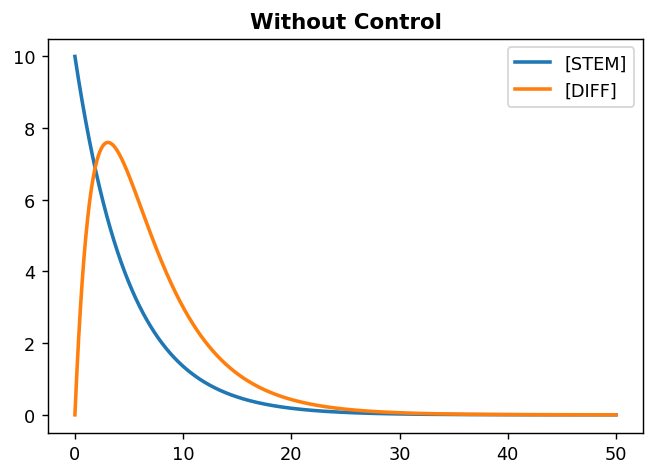

In [216]:
NoControl = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.7',D='0.5',
  Control=['1', '1', '1'], 
  Events=[])
r = te.loada(NoControl)
s = r.simulate(0, 50, 10000) 

r.plot(s, xlabel='Time', ylabel='Population', title= 'Without Control' )

In the absence of control loops, the network will have a very difficult time maintaining homeostasis. 

Control has been formalized differently throughout the literature. Here, we define three distinct forms of control and examine there affects on two and three compartment systems. 

![](./assets/table.png)

First, the original method of control used by Komarova (2013): Where $Population$ denotes the population of the cell stage that is doing the controlling, and $k$ is a parameter. In their work in the olfactory epithelium, Lander et al. (2009), they use a variation on the tradiational hill function, where the population gets muliplied by the parameter $\alpha$. Lastly, we include a generalized Hill function, where $n$ is an exponential parameter, typically set to either values of 4 or 8. 



[***is this the correct way to word this??***]By multiplying the control functions with our parameters, so in the two stage system that would be either our division rate $L$ or our differentiation probability $P$  we can create different network topologies. Excitation and inhibition can be linked in a combinatorial fashion, but not all will produce networks capable of achieving appropriate population homeostasis. 




[***Expand on where control is hooked up in the system -- or first introduce the two networks that do have control and then talk about it.***]

### 2 Two-Stage networks with control: 

In the simplified two stage system, only two network topologies were shown to exhibit homeostasis.

![](./assets/inhib_inhib.png)

In this network, stem cells are inhibiting their own division rate. At the same time, differentiated cells are also inhibiting the probability that stem cells will differentiate. 

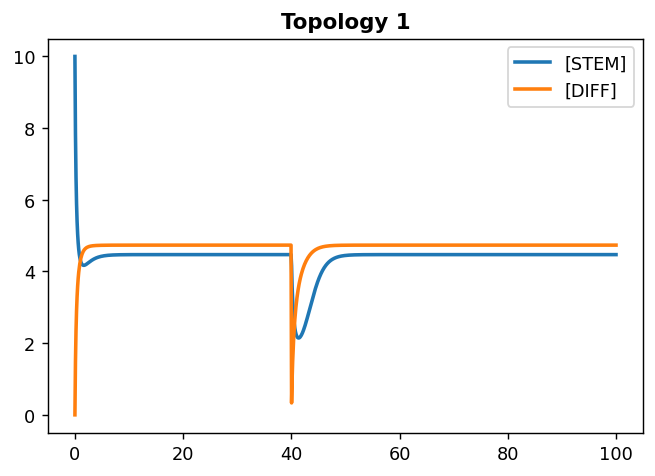

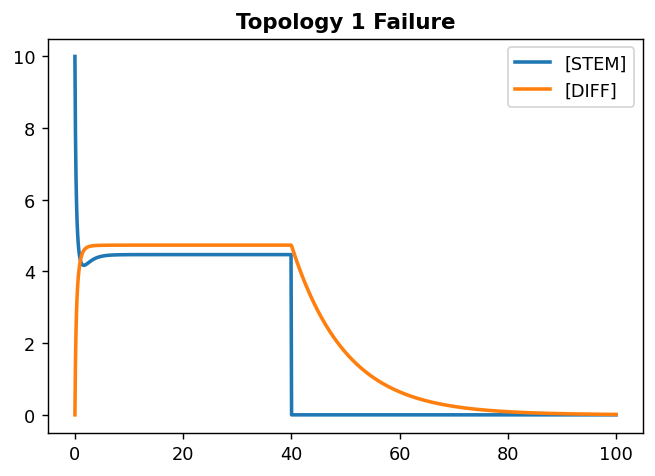

In [218]:
DoubleInhib = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time > 40: DIFF = 0;'])

DoubleInhibFailure = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('DIFF','5'), '1'], 
  Events=['at time > 40: STEM = 0;'])
  
r = te.loada(DoubleInhib)
s = r.simulate(0, 100, 1000)
r.plot(s, xlabel='Time', ylabel='Population', title= 'Topology 1' )
r = te.loada(DoubleInhibFailure)
s = r.simulate(0, 100, 1000)
r.plot(s, xlabel='Time', ylabel='Population', title= 'Topology 1 Failure' )


We can see that the network clearly exhibits populations homeostasis relative to the parameter $k$. The tissue is also incredibly robust to perturbations, as even when the differentiated cell popualation is completely destroyed 40 steps into the simulation, the tissue will still be able to recover. Yet, this is not the caae with our stem cell population, as although it can survive slight perturbations, it is not able to recover from a complete destruction of the population in the same way that differentiated cells can.

![](./assets/excite_inhib.png)

In this network, stem cells are increasing the probability that they will differentiate, while differentiated cells inhibit their rate of division. 

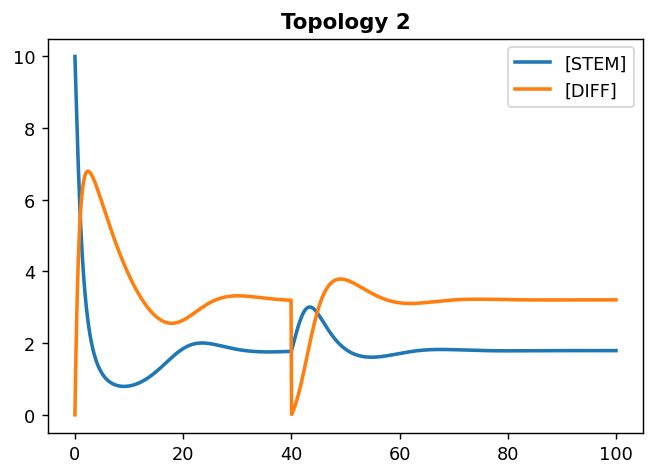

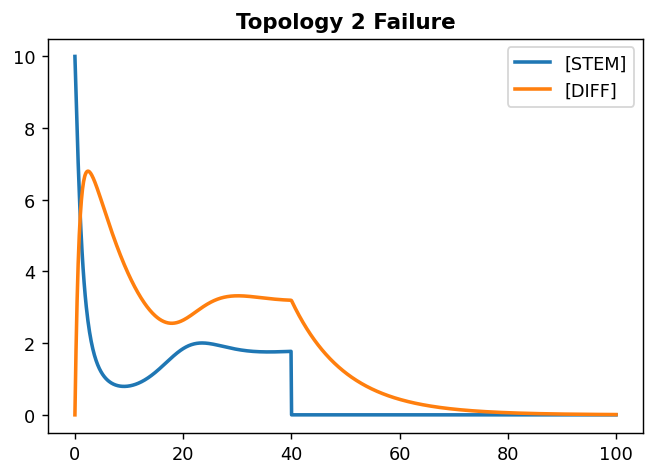

In [220]:
InhibExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=['at time> 40: DIFF = 0;'])
InhibExciteFail = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='0.5',P='0.5',D='0.1',
  Control=[inhib['komarova']('DIFF','5'), excite['komarova']('STEM','5'), '1'], 
  Events=['at time> 40: STEM = 0;'])

r = te.loada(InhibExcite)
s = r.simulate(0, 100, 1000)
r.plot(s, xlabel='Time', ylabel='Population', title= 'Topology 2' )
r = te.loada(InhibExciteFail)
s = r.simulate(0, 100, 1000)
r.plot(s, xlabel='Time', ylabel='Population', title= 'Topology 2 Failure' )


### A two stage model where death rate is not a constant:

There are specific cases where the death rate of differentiated cells is not a constant 


In the two stage system there are 2 topologies  the 20 different topologies all have a constant death rate. There are some cases where this is not the case. For example, ... . This added nuance has been captured in the expansion of the model by axelrod ... (CITE). This added factor produced 12 additional models on top of the initial 20, but only 1 of which is biologically realistic.

The following system excites stem cell division rate while also exciting the death rate of terminally differentiated cells. While this model does exhibit homeostasis, it is incredibly fragile to perturbations. Below, we can see that even a minor hit to the population of differentiated cells will kill off the entire population of stem cells 10 steps later. 

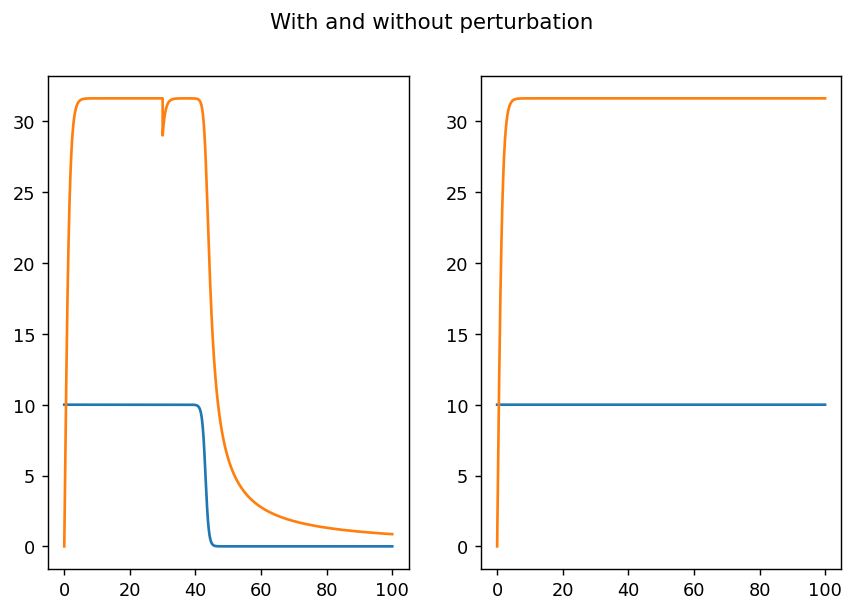

In [185]:
ExciteExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[excite["komarova"]('STEM', 5), '1', excite["komarova"]('DIFF', 5)], 
  Events=['at time > 30: DIFF = 29;'])
ExciteExcite2 = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[excite["komarova"]('STEM', 5), '1', excite["komarova"]('DIFF', 5)], 
  Events=[])

r = te.loada(ExciteExcite)
r2 = te.loada(ExciteExcite2)
s = r.simulate(0, 100, 10000, ['STEM', 'DIFF'])
s2 = r2.simulate(0, 100, 10000, ['STEM', 'DIFF'])
#r.plot(s)
time = np.arange(0, 100, 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('With and without perturbation')
ax1.plot(time, s)
ax2.plot(time, s2)

# This one is iteresting because it survives, is robust to perturbations, and was not reported as being stable in the literature. 

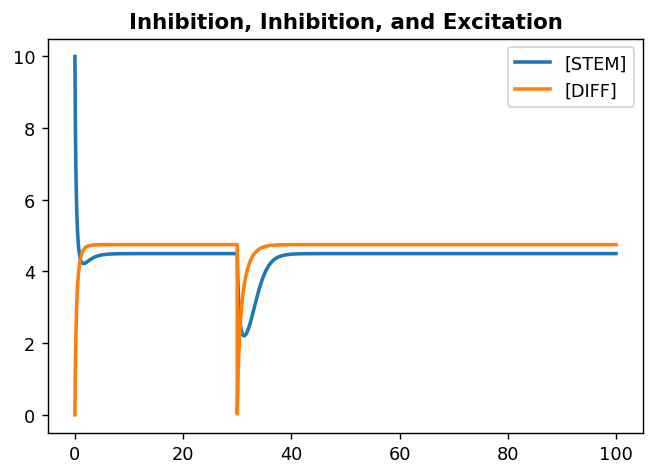

In [213]:
InhibInhibExcite = twoCompartmentModel(
  STEM='10', DIFF='0', 
  L='1',P='1',D='0.1',
  Control=[inhib["komarova"]('STEM', 5), inhib["komarova"]('DIFF', 5), excite["komarova"]('DIFF', 5)], 
  Events=['at time > 30: DIFF = 0;'])
r = te.loada(InhibInhibExcite)
s = r.simulate(0, 100, 10000)
r.plot(s, xlabel='Time', ylabel='Population', title= 'Inhibition, Inhibition, and Excitation')


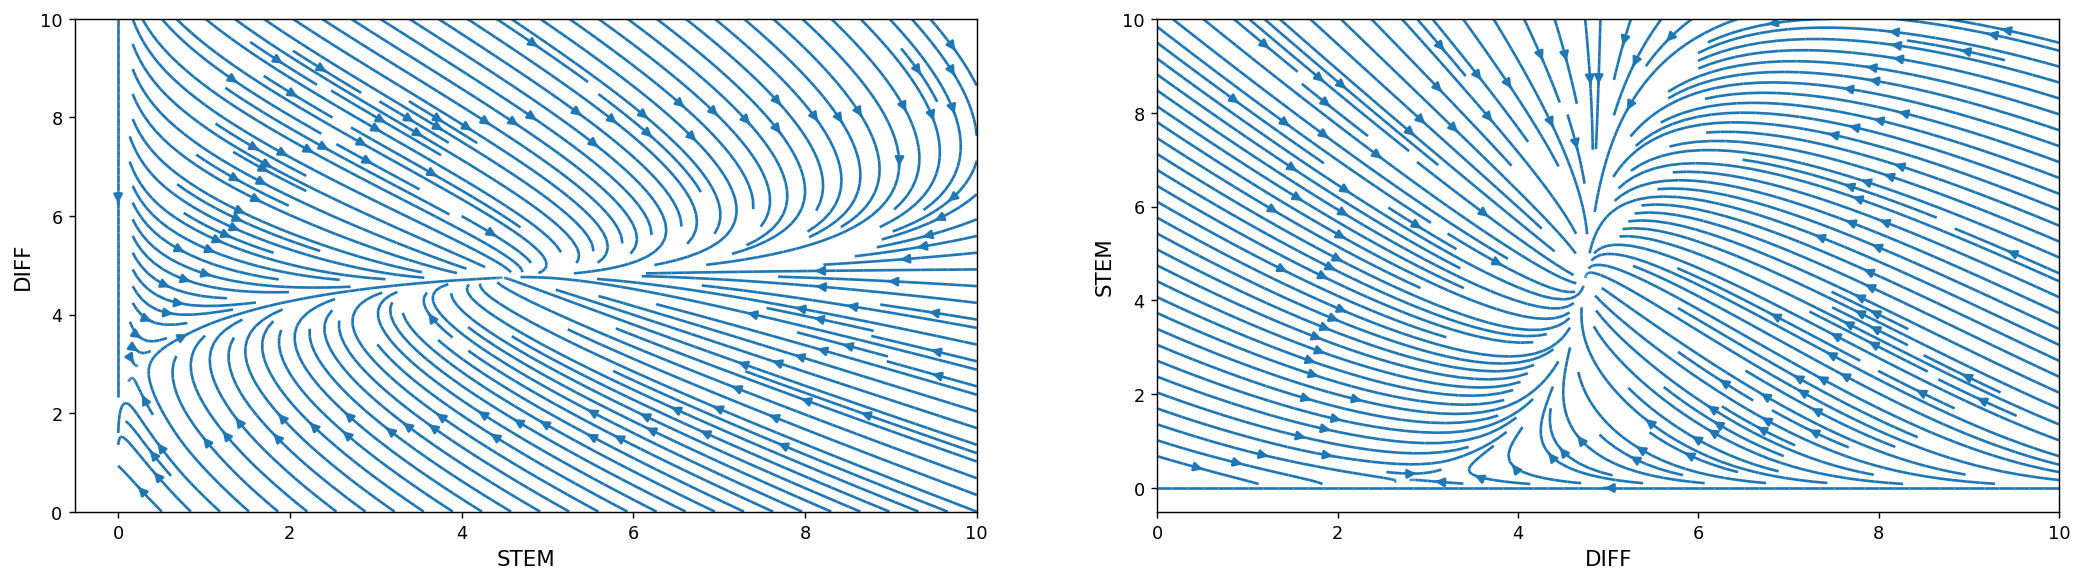

In [187]:
plotFlow(InhibInhibExcite, compartments=2)

### A three stage network with control: 

In [188]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[])

r = te.loada(model)
#print(te.getODEsFromModel(r))
# r.simulate(0, 1000, 10000)
# r.plot()
# print(model)


The three stage cell lineage is similar to our previous model, but with the addition of a transit-amplifying cell. These cells are XXX [***Information about transit amplifiers and the reason that they are to be included***]. 

More than a step above our two stage system, the three stage system produces 20 topologies capable of producing tissue homeostasis. Although, it has been shown that that only 2 of these result in biologically realistic tissue homeostasis (Yang, Axelrod, and Komarova; 2017).



#### [Instead of going through the same process of with or without control, we can just show the 20 different topologies and then show the 2 that are biologically realistic. We will also expand the the model to include a new form of control loop that we see in the axelrod and komarova paper.]

Topology #1

![](./assets/Topology_1.png)

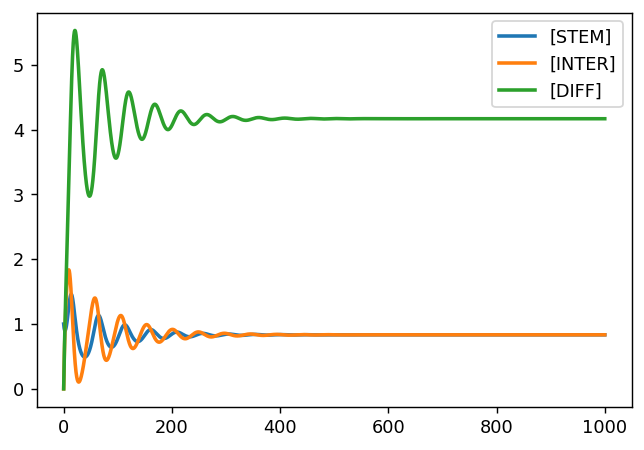

In [189]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[])

r = te.loada(model)
r.simulate(0, 1000, 10000)
r.plot()



In [190]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','10'), inhib['komarova']('INTER','10'), inhib['komarova']('DIFF','10'), '1','1'],
  Events=[
  ])

## Flow Diagrams

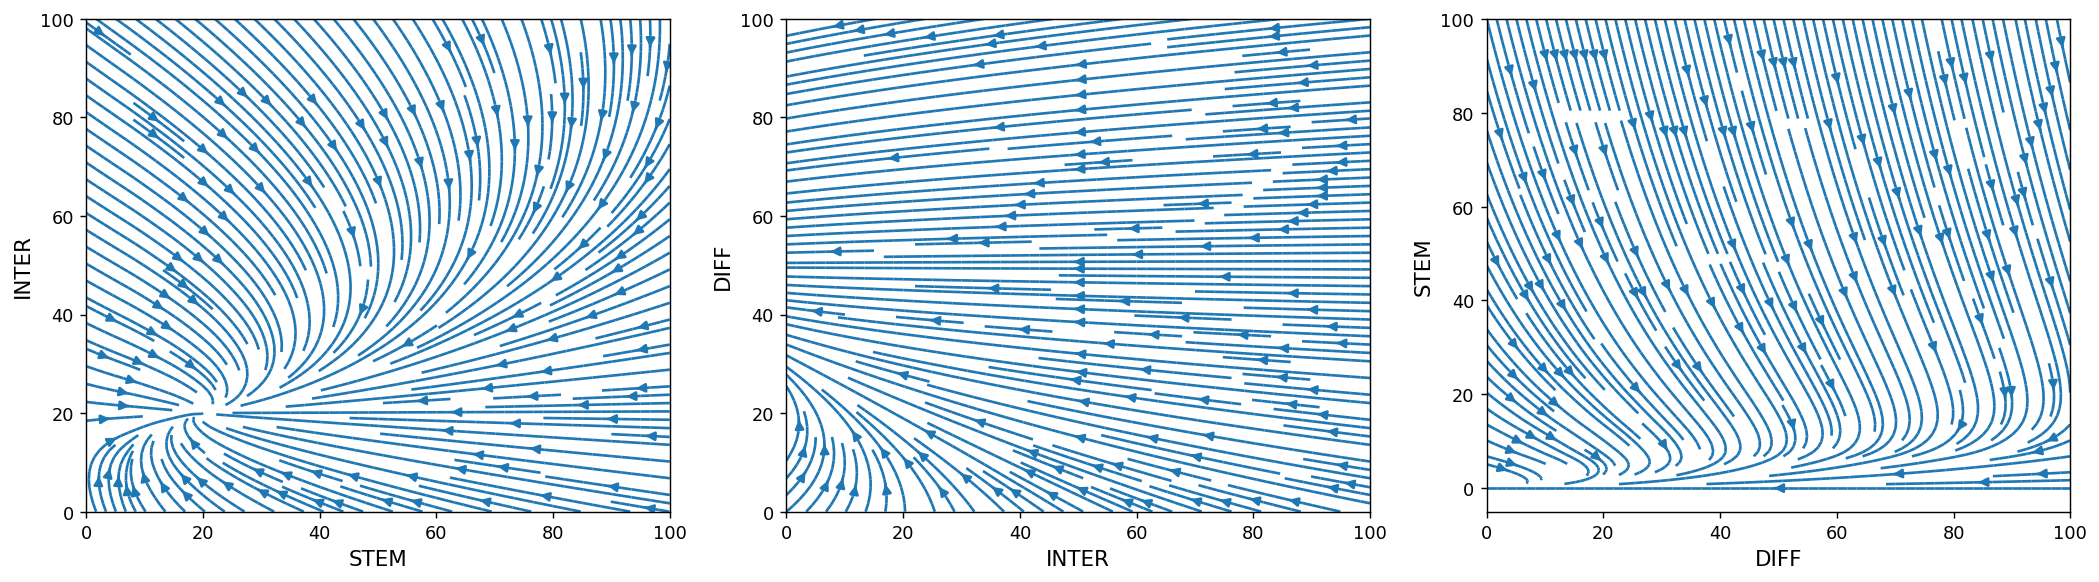

In [191]:
# FLOW PLOTS FOR THE ABOVE SYSTEM
# TODO: create an array of all 3 compartment model control systems and then run them all to see flows
model = threeCompartmentModel(
  STEM='10', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','20'), inhib['komarova']('INTER','20'), inhib['komarova']('DIFF','20'), '1','1'],
  Events=[
  ])
# r = te.loada(model)
# r.simulate(0, 1000, 10000)
# r.plot()
# print(getMathematicaODEs(r))
plotFlow(model, max=100)

In [192]:
def labelBox(label, widget):
    return widgets.VBox(
        children=[
            widgets.Label(value=label),
            widget
        ]
    )

STEM=widgets.FloatSlider(min=0, max=100, step=1, value=10, continuous_update=False)
INTER=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
box1 = widgets.HBox(
    [labelBox('Stem',STEM),
    labelBox('TAC',INTER),
    labelBox('Differentiated',DIFF)], 
    description='Initial Values')

L_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
L_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
box2 = widgets.HBox([
    labelBox('Stem',L_S),
    labelBox('TAC',L_I)])

P_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
P_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
box3 = widgets.HBox([
    labelBox('Stem → TAC',P_S),
    labelBox('TAC → Differentiated',P_I)])

D=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False)

ControlType = widgets.ToggleButtons(
    options=['komarova', 'lander', 'hill'],
    disabled=False,
    button_style='',
    tooltips=['pop/k', 'pop/(1+a*pop)', 'pop^n/(1+a*pop^n)'],
)

controlParam=widgets.FloatSlider(min=0, max=200, step=0.1, value=20, continuous_update=False)

inputs = widgets.VBox([
    widgets.HTML('<font size="+1">Initial Populations</font>'),box1,
    widgets.HTML('<font size="+1">Division Rates</font>'), box2,
    widgets.HTML('<font size="+1">Differentiation Probability</font>'), box3,
    widgets.HTML('<font size="+1">Death Rate</font>'), D,
    widgets.HTML('<font size="+1">Control Mechanism</font>'), ControlType,
    widgets.HTML('<font size="+1">Control Parameter</font>'), controlParam
    ])

out = widgets.interactive_output(plotFlow3Compartment, {
    'STEM': STEM, 'INTER': INTER, 'DIFF': DIFF,
    'L_S':L_S,'P_S':P_S,
    'L_I':L_I,'P_I':P_I,
    'D':D,
    'controlType':ControlType,
    'controlParam':controlParam})

display(inputs,out)

Output()

Topology #2

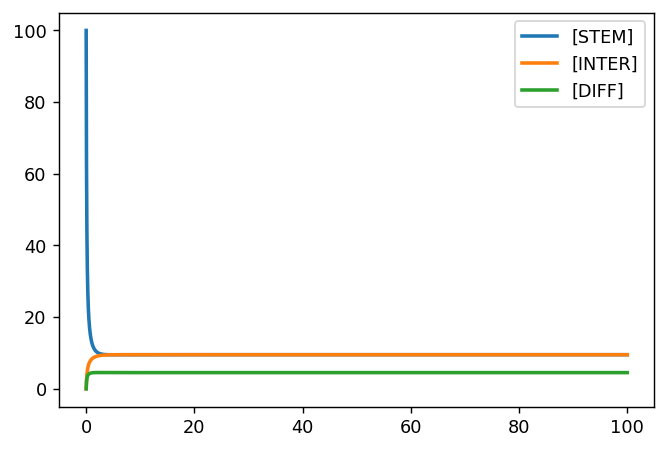

In [193]:
model = threeCompartmentModel(
  STEM='100', INTER='0', DIFF='0', 
  L_S='0.5',P_S='.5',L_I='.5',P_I='.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', inhib['komarova']('DIFF','5'),'1'],
  Events=[])

r = te.loada(model)
r.simulate(0, 100, 10000)
r.plot()

### Axelrod and Komarova's Topology: 

![](./assets/AxelrodTopo.png)

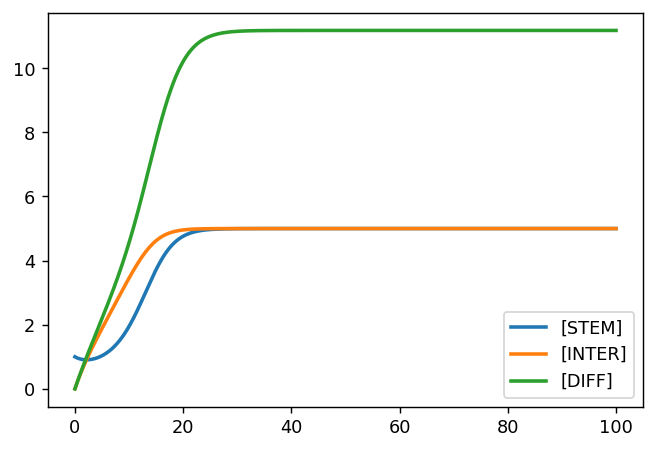

In [194]:
model = threeCompartmentModel(
 STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), '1', '1', excite['komarova']('DIFF','5')],
  Events=[])

r = te.loada(model)
r.simulate(0, 100, 10000)
r.plot()

### Dynamical Analysis of the three stage system:

### Perturbation analysis

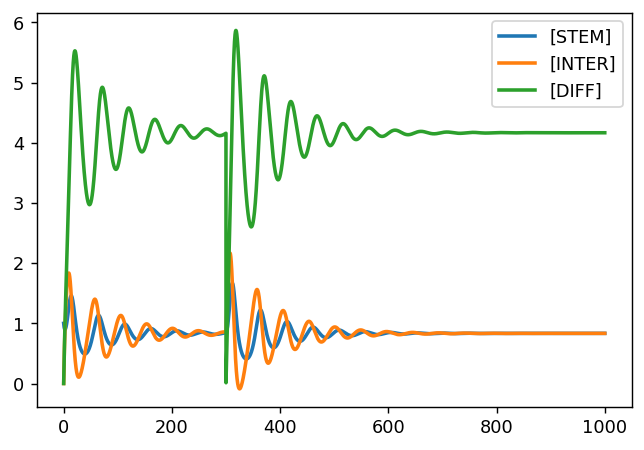

In [195]:
model = threeCompartmentModel(
  STEM='1', INTER='0', DIFF='0', 
  L_S='0.5',P_S='0.5',L_I='0.5',P_I='0.5',D='0.1',
  Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
  Events=[
    'at (time > 300): DIFF = 0'
  ])

r = te.loada(model)
r.simulate(0, 1000, 10000)
r.plot()



One of the markers of a biologically realistic circuit is one that exhibits oscillatory recovery. [expand and cite the studies that the axelrod paper mentions]

In [196]:
modeltest = ('''
   
    # Initialized Populations
    STEM = 1;
    INTER = 0;
    DIFF = 0;

    # Parameters
    L_S = 0.5;
    P_S = 0.5;
    L_I = 0.5;
    P_I = 0.5;
    D = 0.1;
    
    # DIVISION RATE OF STEM CELLS
    L_S = 0.5;

    # Rate of Division of Stem Cells
    ES_2S: STEM -> 2STEM; L_S * STEM * (1-(STEM/5));

    # Rate of Differentiation of Stem Cells
    ES_I:  STEM -> INTER; P_S * 2 * 0.5 * STEM * (1-(INTER/5));

    # Rate of Division of Intermediate Cells
    EI_2I: INTER -> 2INTER; L_I * STEM * (1-(DIFF/5));

    # Rate of Differentiation of Intermediate Cells
    ES_D:  INTER -> DIFF; P_I * 2 * 0.5 * STEM * (1);

    # Rate of Death of Differentiated Cells 
    ED_D: DIFF -> ; D * DIFF * (1);

    ''')

# model = threeCompartmentModel(
#   STEM='1', INTER='0', DIFF='0', 
#   LS='0.5',PS='0.5',LI='0.5',PI='0.5',D='0.1',
#   Control=[inhib['komarova']('STEM','5'), inhib['komarova']('INTER','5'), inhib['komarova']('DIFF','5'), '1','1'],
#   Events=[])



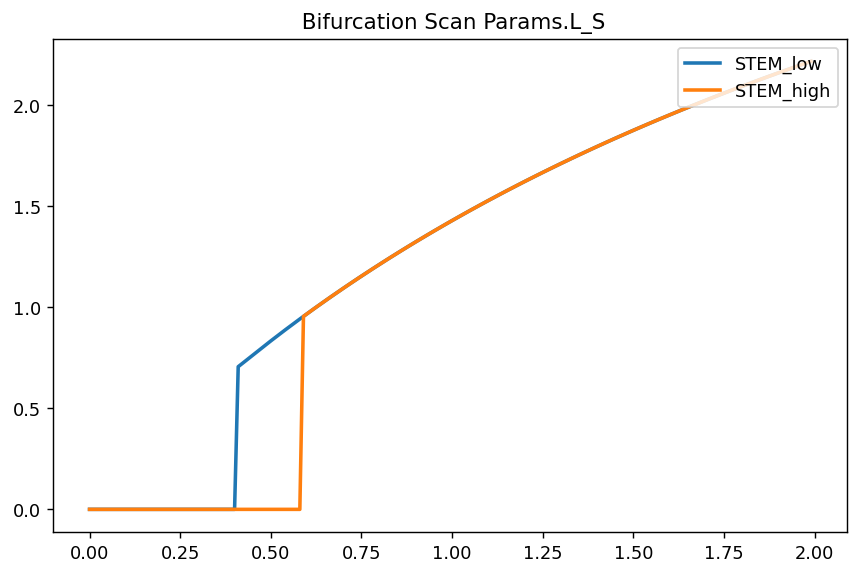

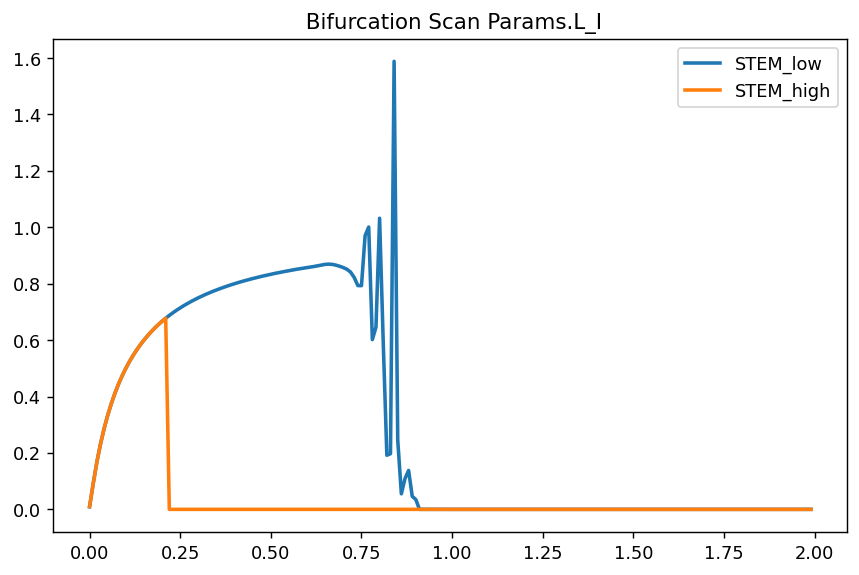

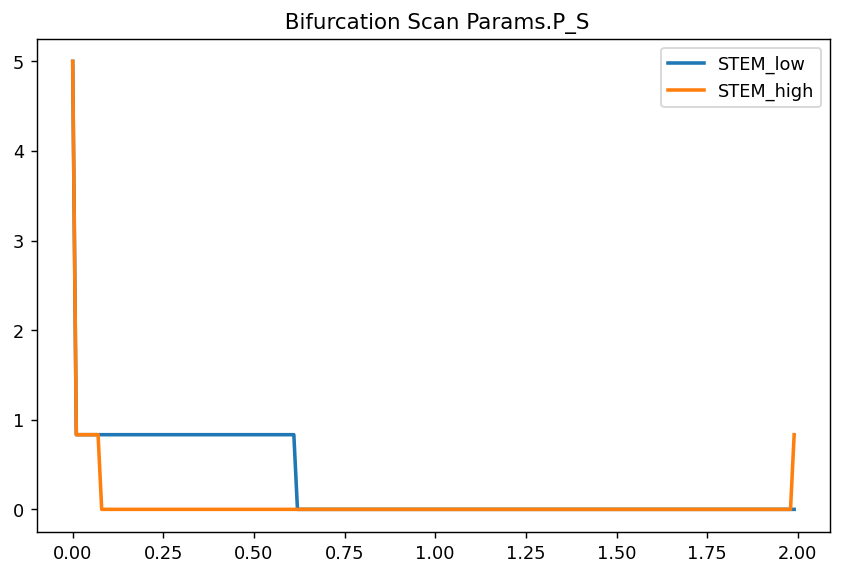

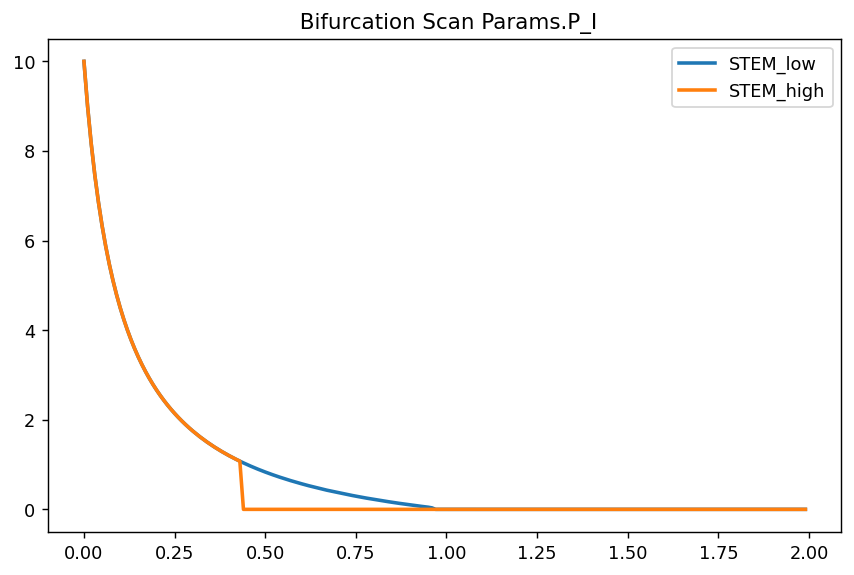

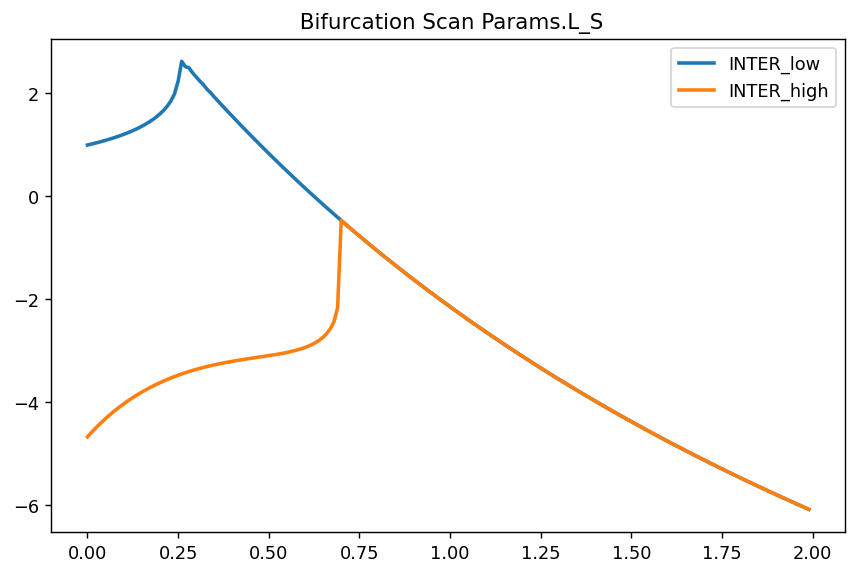

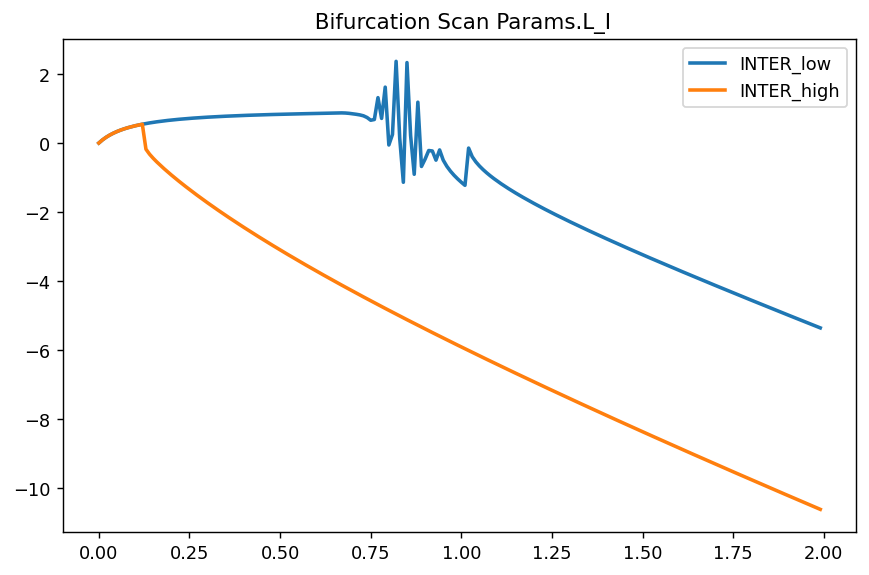

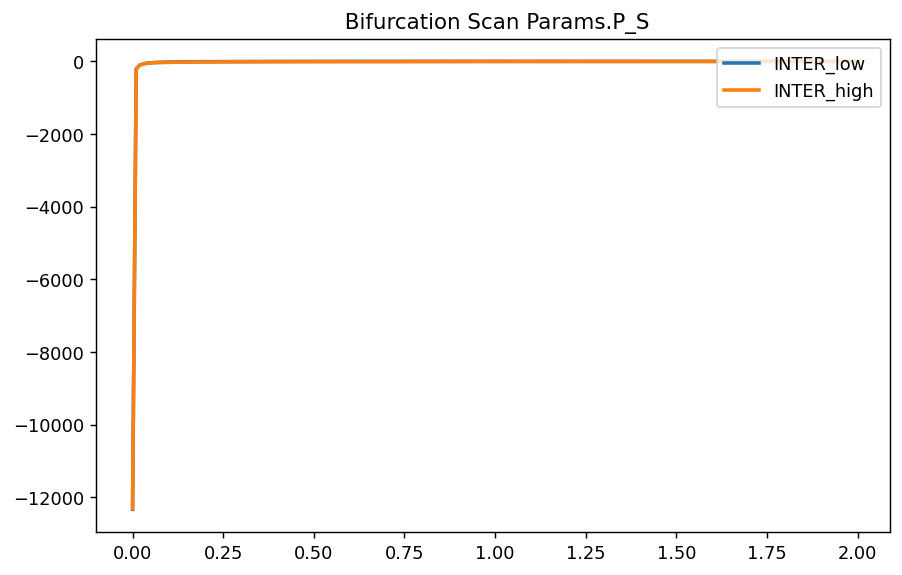

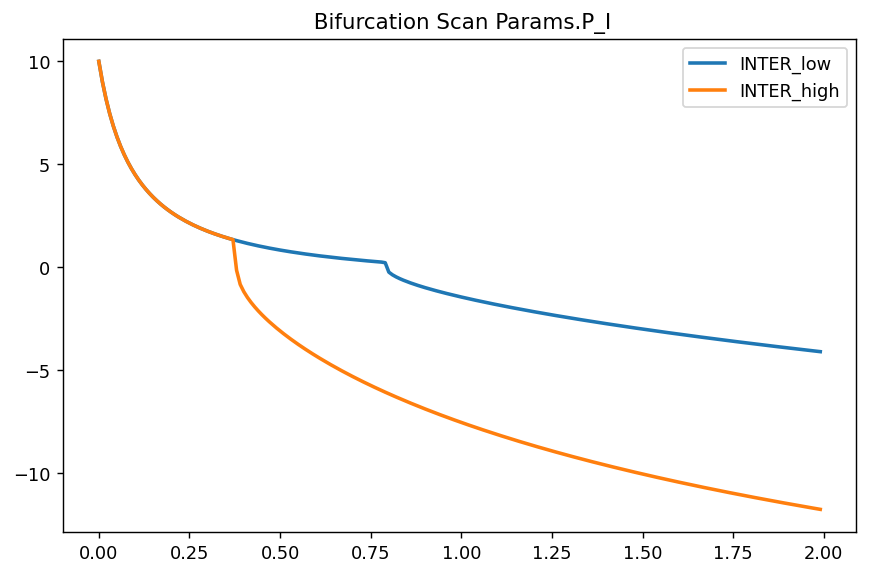

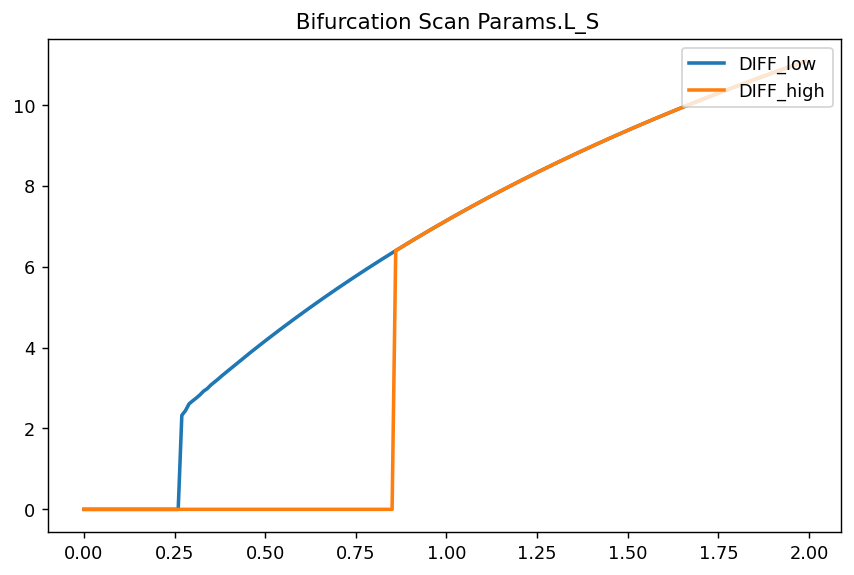

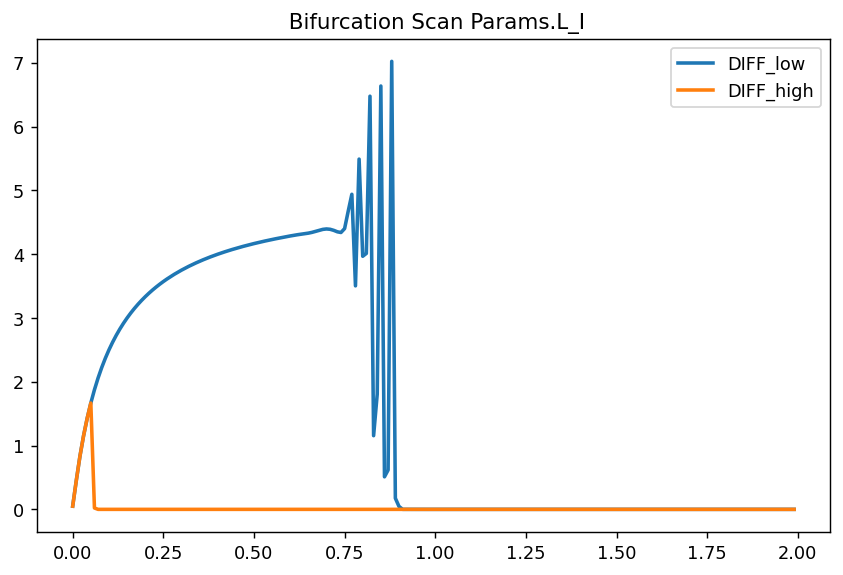

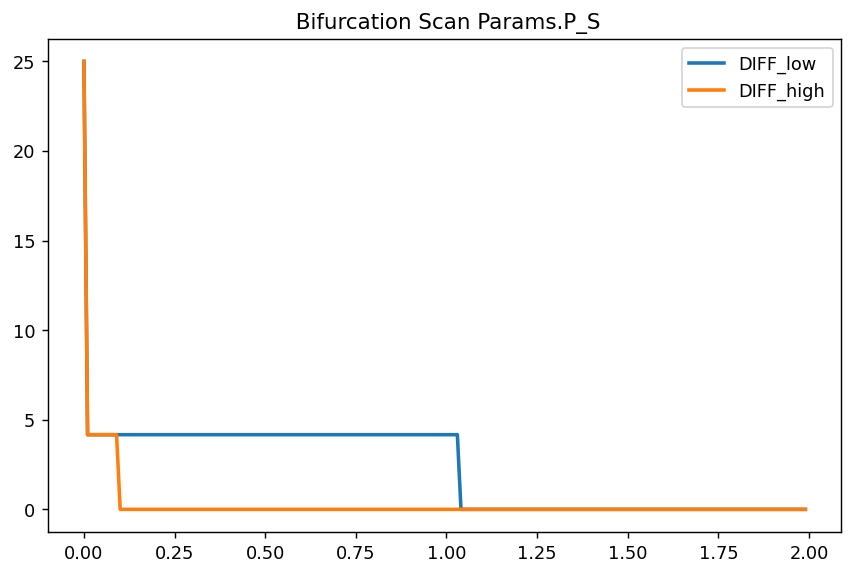

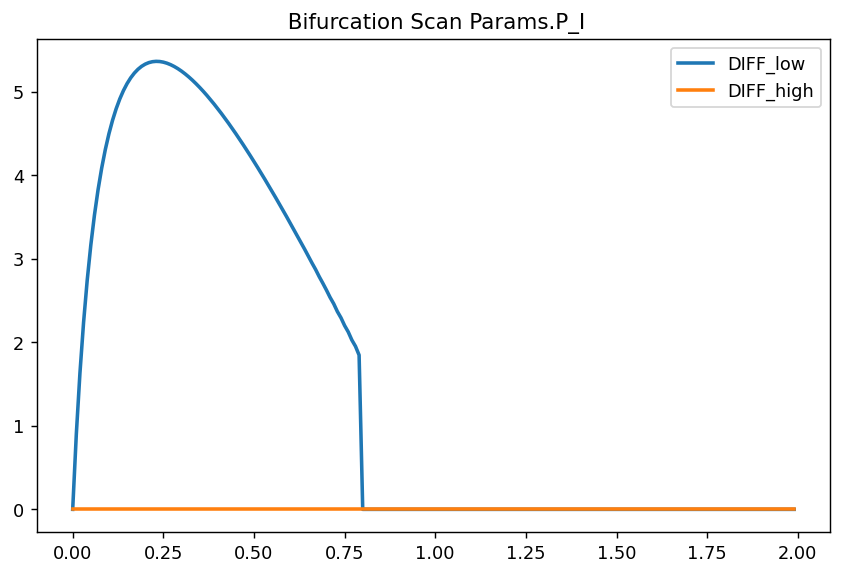

In [197]:

# printHighLowBifurcationScan(modeltest, scanningParam=Params.LS, range= np.arange(0, 10, 0.01))
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I)

printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S, highLow= Params.INTER)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I, highLow= Params.INTER)

printHighLowBifurcationScan(modeltest, scanningParam=Params.L_S, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.L_I, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_S, highLow= Params.DIFF)
printHighLowBifurcationScan(modeltest, scanningParam=Params.P_I, highLow= Params.DIFF)


In [198]:
def modelGeneratorTWO(STEM_value: int, DIFF_value: int, L_value: float, P_value: float, D_value: float,# Inintial values 
                      Control_typeFirst: str, Control_typeSecond: str, Control_typeThird: str,         # inhib, excite or none
                      Control_design: str,                                                             # Komarova, Lander or Hill                      
                      Control_speciesFirst: str, Control_speciesSecond: str, Control_speciesThird: str,# STEM, DIFF
                      Control_kFirst: str, Control_kSecond: str, Control_kThird: str,                  # value of a
                      Events_T: bool,                                                                  # enable event 
                      Events_time: int, Events_species: str, Events_Svalue: int,                       # event parameters
                      Simulate_time: int):                                                             # Max Time of the simulation
    
    # Parameter definition    
    Control_value=[]
    # S->2S
    if Control_typeFirst == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFirst, str(Control_kFirst)))
    elif Control_typeFirst == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFirst, str(Control_kFirst)))  
    else:        
        Control_value.append('1')  
    # S->D
    if Control_typeSecond == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesSecond, str(Control_kSecond)))
    elif Control_typeSecond == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesSecond, str(Control_kSecond)))  
    else:        
        Control_value.append('1')  
    # D-> 
    if Control_typeThird == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesThird, str(Control_kThird)))
    elif Control_typeThird == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesThird, str(Control_kThird)))  
    else:        
        Control_value.append('1')          
  
    # Event definition    
    if Events_T:                
        Events_value=['at time > {t}: {s} = {v};'.format(t=Events_time, s=Events_species, v=Events_Svalue)]
    else:
        Events_value=[]
    
    # Model Generation    
    model = twoCompartmentModel(STEM=STEM_value,DIFF=DIFF_value,L=L_value,P=P_value,D=D_value,Control=Control_value,Events=Events_value) 
    print(model)
    
    # Tellurium Simulation   
    r = te.loada(model)    
    s = r.simulate(0, Simulate_time, Simulate_time*10)
    
    # Population Plotting 
    plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams['figure.dpi'] = 128
    plt.plot(s['time'],s['[STEM]'], label="Stem")
    plt.plot(s['time'],s['[DIFF]'], label="Diferentiated")
    plt.legend()
    plt.grid()
    plt.title('Population Graph', fontweight="bold", fontsize = 15)
    plt.xlabel("Time")
    plt.ylabel("Cell Count")
    plt.show()
    
    # Flow Analysis
    plotFlow(model, compartments=2)
        
    # Bifurcation Analysis
    printHighLowBifurcationScan(model, scanningParam=Params.L, highLow= Params.STEM) # example not doing what I wanted with axis subplot
   
      
    
    
    # printHighLowBifurcationScan()

In [199]:
def labelBox(label, widget):
    return widgets.VBox(
        children=[
            widgets.Label(value=label),
            widget
        ]
    )

In [200]:

def twoCompartmentWidgets():
    STEM=widgets.FloatSlider(min=0, max=100, step=1, value=1, continuous_update=False)
    STEM.style.handle_color = 'lightblue'

    DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
    DIFF.style.handle_color = 'lightblue'

    box1 = widgets.HBox(
        [labelBox('Stem',STEM),        
        labelBox('Differentiated',DIFF)], 
        description='Initial Values')

    L=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    L.style.handle_color = 'lightblue'

    box2 = widgets.HBox([
        labelBox('Stem',L)])

    P=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    P.style.handle_color = 'lightblue'

    box3 = widgets.HBox([
        labelBox('Stem → Differentiated',P)])

    D=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False)
    D.style.handle_color = 'lightblue'

    ControlType = widgets.ToggleButtons(options=[('Komarova', 'komarova'), ('Lander', 'lander'), ('Hill', 'hill')],
                                        disabled=False, button_style='info',
                                        tooltips=['Promote = pop/a\nInhibit = 1-(pop/a)',
                                                'Promote = pop/(1+a*pop)\nInhibit = 1/(1+a*pop)',
                                                'Promote = (pop^4)/(1+(a*pop)^4)\nInhibit = 1/(1+(a*pop)^4)'])

    Control_type1= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type2= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type3= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',) 

    controlParam1=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam2=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam3=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)

    Control_species1= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',)
    Control_species2= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='DIFF', disabled=False, button_style='info',)
    Control_species3= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',) 

    box4a = widgets.HBox([
        labelBox('Stem → 2Stem',Control_type1),
        labelBox('\'a\' value',controlParam1),
        labelBox('Species Controling',Control_species1)])

    box4b = widgets.HBox([    
        labelBox('Stem → Differentiated',Control_type2),
        labelBox('\'a\' value',controlParam2),
        labelBox('Species Controling',Control_species2)])

    box4c = widgets.HBox([
        labelBox('Differentiated → ',Control_type3),
        labelBox('\'a\' value',controlParam3),
        labelBox('Species Controling',Control_species3)])

    Events_T_w= widgets.Checkbox(value=False, description='Create an Event', disabled=False)

    Events_time_w= widgets.IntSlider(min=0, max=100, step=1, value=50, continuous_update=False)
    Events_time_w.style.handle_color = 'lightblue'

    Events_species_w= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Differentiated', 'DIFF')],
                                                                value='DIFF', disabled=False, button_style='info',)

    Events_Svalue_w= widgets.IntSlider(min=0, max=150, step=1, value=0, continuous_update=False, disabled=False)
    Events_Svalue_w.style.handle_color = 'lightblue'

    Simulate_time_w= widgets.IntSlider(value=200,min=150,max=1500,step=1,description='Text:',disabled=False)
    Simulate_time_w.style.handle_color = 'lightblue'
                        
    box5 = widgets.HBox([
        labelBox('Create an Event',Events_T_w),
        labelBox('Time of Event',Events_time_w),
        labelBox('Species',Events_species_w),
        labelBox('Set Species Value',Events_Svalue_w)    
        ])

    inputs = widgets.VBox([
        widgets.HTML('<font size="+1">Initial Populations</font>'),box1,
        widgets.HTML('<font size="+1">Division Rates</font>'), box2,
        widgets.HTML('<font size="+1">Differentiation Probability</font>'), box3,
        widgets.HTML('<font size="+1">Death Rate</font>'), D,
        widgets.HTML('<font size="+1">Control Mechanism</font>'), ControlType,
        widgets.HTML('<font size="+1">Division Control Parameters</font>'), box4a,
        widgets.HTML('<font size="+1">Differentiation Control Parameters</font>'), box4b,
        widgets.HTML('<font size="+1">Death Control Parameters</font>'), box4c,
        widgets.HTML('<font size="+1">Simulation Max Time</font>'), Simulate_time_w,
        widgets.HTML('<font size="+1">Events</font>'), box5
        ])

    out = widgets.interactive_output(modelGeneratorTWO, {
        'STEM_value':STEM, 'DIFF_value':DIFF,
        'L_value':L,'P_value':P,'D_value':D,
        'Control_design':ControlType,
        'Control_typeFirst':Control_type1,'Control_typeSecond':Control_type2,'Control_typeThird':Control_type3,
        'Control_kFirst':controlParam1,'Control_kSecond':controlParam2,'Control_kThird':controlParam3,
        'Control_speciesFirst': Control_species1, 'Control_speciesSecond':Control_species2, 'Control_speciesThird': Control_species3,
        'Events_T':Events_T_w,'Events_time':Events_time_w, 'Events_species':Events_species_w, 'Events_Svalue':Events_Svalue_w,
        'Simulate_time':Simulate_time_w
        })

    display(inputs,out)
           

In [201]:
twoCompartmentWidgets()

Output()

In [202]:
def modelGeneratorTHREE(STEM_value: int,INTER_value: int, DIFF_value: int,
                        L_Ivalue: float,L_Svalue: float,
                        P_Ivalue: float,P_Svalue: float,
                        D_value: float, 
                        
                        Control_typeFirst: str, Control_typeSecond: str,
                        Control_typeThird: str,  Control_typeFourth: str,
                        Control_typeFifth: str,
                        
                        Control_design: str,  
                             
                        Control_speciesFirst: str, Control_speciesSecond: str,
                        Control_speciesThird: str, Control_speciesFourth: str,
                        Control_speciesFifth: str,
                        
                        Control_kFirst: str, Control_kSecond: str, Control_kThird: str,
                        Control_kFourth: str, Control_kFifth: str,
                        
                        Events_T: bool,
                        Events_time: int, Events_species: str, Events_Svalue: int,
                        Simulate_time: int):                                      
    
    
    Control_value=[]
    # S->2S
    if Control_typeFirst == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFirst, Control_kFirst))
    elif Control_typeFirst == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFirst, Control_kFirst))  
    else:        
        Control_value.append('1')  
    # S->I
    if Control_typeSecond == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesSecond, Control_kSecond))
    elif Control_typeSecond == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesSecond, Control_kSecond))  
    else:        
        Control_value.append('1')  
    # I->2I
    if Control_typeThird == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesThird, Control_kThird))
    elif Control_typeThird == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesThird, Control_kThird))  
    else:        
        Control_value.append('1')                    
    # I->D
    if Control_typeFourth == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFourth, Control_kFourth))
    elif Control_typeFourth == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFourth, Control_kFourth))  
    else:        
        Control_value.append('1')       
    # D->
    if Control_typeFifth == 'Inhibit':        
        Control_value.append(inhib[Control_design](Control_speciesFifth, Control_kFifth))
    elif Control_typeFifth == 'Promote':        
        Control_value.append(excite[Control_design](Control_speciesFifth, Control_kFifth))  
    else:        
        Control_value.append('1')              
        
    if Events_T:                
        Events_value=['at time > {t}: {s} = {v};'.format(t=Events_time, s=Events_species, v=Events_Svalue)]
    else:
        Events_value=[]
        
    model = threeCompartmentModel(STEM=STEM_value,INTER=INTER_value,DIFF=DIFF_value,
                                  L_S=L_Svalue, P_S=P_Svalue, 
                                  L_I=L_Ivalue, P_I=P_Ivalue,
                                  D=D_value,Control=Control_value,Events=Events_value) 
    print(model)   
    r = te.loada(model)    
    s = r.simulate(0, Simulate_time, Simulate_time*10)
    
    # Population Plotting 
    plt.rcParams["figure.figsize"] = (8,5)
    plt.rcParams['figure.dpi'] = 128
    plt.plot(s['time'],s['[STEM]'], label="Stem")
    plt.plot(s['time'],s['[INTER]'], label="Intermediate")
    plt.plot(s['time'],s['[DIFF]'], label="Diferentiated")
    
    plt.legend()
    plt.grid()
    plt.title('Population Graph', fontweight="bold", fontsize = 15)
    plt.xlabel("Time")
    plt.ylabel("Cell Count")
    plt.show()
    
    # Flow Analysis
    plotFlow(model, compartments=3)
        
    # Bifurcation Analysis
    printHighLowBifurcationScan(model, scanningParam=Params.L_I, highLow= Params.STEM) # example not doing what I wanted with axis subplot
    
    



In [203]:
def threeCompartmentWidgets():
    # Initial Values
    STEM=widgets.FloatSlider(min=0, max=100, step=1, value=1, continuous_update=False)
    STEM.style.handle_color = 'lightblue'

    INTER=widgets.FloatSlider(min=0, max=100, step=1, value=1, continuous_update=False)
    INTER.style.handle_color = 'lightblue'
    
    DIFF=widgets.FloatSlider(min=0, max=100, step=1, value=0, continuous_update=False)
    DIFF.style.handle_color = 'lightblue'

    box1 = widgets.HBox(
        [labelBox('Stem',STEM),
        labelBox('Intermediate',INTER),
        labelBox('Differentiated',DIFF)], 
        description='Initial Values')
     
    L_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    L_S.style.handle_color = 'lightblue'
    
    L_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    L_I.style.handle_color = 'lightblue'
    
    box2 = widgets.HBox([
        labelBox('Stem',L_S),
        labelBox('Intermediate',L_I)])
       

    P_S=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    P_S.style.handle_color = 'lightblue'
    
    P_I=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, continuous_update=False)
    P_I.style.handle_color = 'lightblue'
    
    box3 = widgets.HBox([
        labelBox('Stem → Intermediate',P_S),
        labelBox('Intermediate → Differentiated',P_I)])

    D=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.1, continuous_update=False)
    D.style.handle_color = 'lightblue'

    # Control Parameters
    ControlType = widgets.ToggleButtons(options=[('Komarova', 'komarova'), ('Lander', 'lander'), ('Hill', 'hill')],
                                        disabled=False, button_style='info',
                                        tooltips=['Promote = pop/a\nInhibit = 1-(pop/a)',
                                                'Promote = pop/(1+a*pop)\nInhibit = 1/(1+a*pop)',
                                                'Promote = (pop^4)/(1+(a*pop)^4)\nInhibit = 1/(1+(a*pop)^4)'])

    Control_type1= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type2= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type3= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type4= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)
    Control_type5= widgets.ToggleButtons(options=['None', 'Inhibit', 'Promote'],
                                            value='None', disabled=False, button_style='info',)  

    controlParam1=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam2=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam3=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam4=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)
    controlParam5=widgets.BoundedIntText(value=5,min=1,max=100,step=1,disabled=False)

    Control_species1= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',)
    Control_species2= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                            value='DIFF', disabled=False, button_style='info',)
    Control_species3= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',) 
    Control_species4= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                            value='DIFF', disabled=False, button_style='info',)
    Control_species5= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                            value='STEM', disabled=False, button_style='info',) 

    box4a = widgets.HBox([
        labelBox('Stem → 2Stem',Control_type1),
        labelBox('\'a\' value',controlParam1),
        labelBox('Species Controling',Control_species1)])

    box4b = widgets.HBox([    
        labelBox('Stem → Intermediate',Control_type2),
        labelBox('\'a\' value',controlParam2),
        labelBox('Species Controling',Control_species2)])
    
    box4c = widgets.HBox([    
        labelBox('Intermediate → 2Intermediate',Control_type3),
        labelBox('\'a\' value',controlParam3),
        labelBox('Species Controling',Control_species3)])
    
    box4d = widgets.HBox([    
        labelBox('Intermediate → Differentiated',Control_type4),
        labelBox('\'a\' value',controlParam4),
        labelBox('Species Controling',Control_species4)])

    box4e = widgets.HBox([
        labelBox('Differentiated → ',Control_type5),
        labelBox('\'a\' value',controlParam5),
        labelBox('Species Controling',Control_species5)])

    Events_T_w= widgets.Checkbox(value=False, description='Create an Event', disabled=False)

    Events_time_w= widgets.IntSlider(min=0, max=100, step=1, value=50, continuous_update=False)
    Events_time_w.style.handle_color = 'lightblue'

    Events_species_w= widgets.ToggleButtons(options=[('Stem cells', 'STEM'), ('Intermidiate', 'INTER'), ('Differentiated', 'DIFF')],
                                                                value='DIFF', disabled=False, button_style='info',)

    Events_Svalue_w= widgets.IntSlider(min=0, max=150, step=1, value=0, continuous_update=False, disabled=False)
    Events_Svalue_w.style.handle_color = 'lightblue'

    Simulate_time_w= widgets.IntSlider(value=200,min=150,max=1500,step=1,description='Text:',disabled=False)
    Simulate_time_w.style.handle_color = 'lightblue'
                        
    box5 = widgets.HBox([
        labelBox('Create an Event',Events_T_w),
        labelBox('Time of Event',Events_time_w),
        labelBox('Species',Events_species_w),
        labelBox('Set Species Value',Events_Svalue_w)    
        ])

    inputs = widgets.VBox([
        widgets.HTML('<font size="+1">Initial Populations</font>'),box1,
        widgets.HTML('<font size="+1">Division Rates</font>'), box2,
        widgets.HTML('<font size="+1">Differentiation Probability</font>'), box3,
        widgets.HTML('<font size="+1">Death Rate</font>'), D,
        widgets.HTML('<font size="+1">Control Mechanism</font>'), ControlType,
        
        widgets.HTML('<font size="+1">Stem Division Control Parameters</font>'), box4a,        
        widgets.HTML('<font size="+1">Stem Differentiation Control Parameters</font>'), box4b,
        
        widgets.HTML('<font size="+1">Intermediate Division Control Parameters</font>'), box4c,        
        widgets.HTML('<font size="+1">Intermediate Differentiation Control Parameters</font>'), box4d,
        
        widgets.HTML('<font size="+1">Death Control Parameters</font>'), box4e,
        widgets.HTML('<font size="+1">Simulation Max Time</font>'), Simulate_time_w,
        widgets.HTML('<font size="+1">Events</font>'), box5
        ])

    out = widgets.interactive_output(modelGeneratorTHREE, {
        'STEM_value':STEM,'INTER_value':INTER,'DIFF_value':DIFF,
        'L_Ivalue':L_I,'L_Svalue':L_S,
        'P_Ivalue':P_I,'P_Svalue':P_S,
        'D_value':D,
        'Control_design':ControlType,
        
        'Control_typeFirst':Control_type1,'Control_typeSecond':Control_type2,'Control_typeThird':Control_type3,
        'Control_typeFourth':Control_type4,'Control_typeFifth':Control_type5,
        
        'Control_kFirst':controlParam1,'Control_kSecond':controlParam2,'Control_kThird':controlParam3,
        'Control_kFourth':controlParam4,'Control_kFifth':controlParam5,
        
        'Control_speciesFirst': Control_species1, 'Control_speciesSecond':Control_species2,'Control_speciesThird': Control_species3,
        'Control_speciesFourth': Control_species4, 'Control_speciesFifth':Control_species5,
        
        'Events_T':Events_T_w,'Events_time':Events_time_w, 'Events_species':Events_species_w, 'Events_Svalue':Events_Svalue_w,
        'Simulate_time':Simulate_time_w
        })

    display(inputs,out)    
             

In [204]:
threeCompartmentWidgets()

Output()